# Project 2: Real Estate Valuation Models

## Contents:
- [Background and Task](#Background-and-Task)
- [Imports and Datasets](#Imports-and-Datasets)
- [Data Cleaning/Feature Engineering](#Data-Cleaning/Feature-Engineering)
- [Current Model: OLS Regression](#Current-Model:-OLS-Regression)
- [Data Cleaning for New Model](#Data-Cleaning-for-New-Model)
- [Exploratory Data Analysis and Visualization](#Exploratory-Data-Analysis-and-Visualization)
- [New Models](#New-Models)
- [Conclusions](#Conclusions)
- [Recommendations](#Recommendations)
- [References](#References)

## Background and Task
---
![Ames, Iowa](./images/ames.png "Ames, Iowa")

In this project, I construct multiple regressions within a hypothetical scenario in order to predict the home prices within the township.

Scenario:

It is August, 2010, almost two years after the financial crisis. I am a data scientist for a real estate company, Oppenhouser, that uses in-house valuation model to predict the prices of homes in Ames, Iowa. Management requested for an updated valuation model. My task is to evaluate the current model used by the company and propose a model with better performance given real estate sales data from 2006-2010.

Metrics for success in this scenario are comparisons of valuation metrics for the current and proposed models. All models will be blind-tested on homes sold in 2010, all other homes to be used for training.

For a list of descriptions of the columns contained in the Ames housing datasets, refer to this ([link](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt)).

## Imports and Datasets

In [1]:
# Imports, Functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
from scipy import stats

Loading in real estate data as `'train'`, and splitting it into the train and test subsets:

In [2]:
# Datasets
train = pd.read_csv('./datasets/train.csv')

# Extracting 2010 data from train data set
train_06_09 = train[train['Yr Sold']!=2010].copy()
train_06_09_eda = train[train['Yr Sold']!=2010].copy()
train_10 = train[train['Yr Sold']==2010].copy()
train_10_eda = train[train['Yr Sold']==2010].copy()

## Data Cleaning/Feature Engineering
---
In creating the 'current' model, I did minimal cleaning. I looked at variables that I thought would be good predictors for Sale Price. In the code cell below, `'drop_subset'` is a list of variables of initial interest.

After selecting variables to be used for the 'current' model, I performed the following:

- Three rows total dropped
- Converted columns to appropriate datatypes
- `'Total Full Bath' = 'Full Bath' + 'Bsmt Full Bath'`
- `'Total Half Bath' = 'Half Bath' + 'Bsmt Half Bath'` (not used in OLS)
- `'Total SF' = Gr Liv Area' + 'Total Bsmt SF'`
- Dummified `'Neighborhood'` and `'Overall Cond'`

All steps except for dropping columns replicated on 2010 homes.

In [3]:
# Data Cleaning 06-09

# Dropping nulls in initial subset to be considered for regression model
drop_subset = ['MS SubClass','MS Zoning','Lot Config','Lot Area','Neighborhood','House Style',
    'Bldg Type','Overall Qual','Overall Cond','Year Built','Garage Cars','Kitchen Qual',
    'TotRms AbvGrd','Functional','Pool Area','Sale Type','1st Flr SF','2nd Flr SF','Total Bsmt SF',
    'Gr Liv Area','Bedroom AbvGr','Full Bath','Bsmt Full Bath','Half Bath','Bsmt Half Bath']

train_06_09.dropna(subset=drop_subset, inplace=True)
train_06_09.drop_duplicates(inplace=True)

# Turning floats to integers
flt_to_int = ['Garage Cars','Total Bsmt SF','Bsmt Full Bath','Bsmt Half Bath']
train_06_09[flt_to_int] = train_06_09[flt_to_int].astype(int)
train_06_09['MS SubClass'] = train_06_09['MS SubClass'].astype(object)

# Total SF/Full Bath/Half Bath
train_06_09['Total Full Bath'] = train_06_09['Full Bath'] + train_06_09['Bsmt Full Bath']
train_06_09['Total Half Bath'] = train_06_09['Half Bath'] + train_06_09['Bsmt Half Bath']
train_06_09['Total SF'] = train_06_09['Gr Liv Area'] + train_06_09['Total Bsmt SF']
train_06_09['Overall QualCond'] = train_06_09['Overall Qual'] * train_06_09['Overall Cond']

# Dummifying columns
train_06_09 = pd.get_dummies(train_06_09,columns=['Neighborhood','Overall QualCond',
                                            'Overall Cond','MS SubClass'],drop_first=True)

In [4]:
# Replicating cleaning steps and reindexing 2010 columns

# Turning floats to integers
flt_to_int = ['Garage Cars','Total Bsmt SF','Bsmt Full Bath','Bsmt Half Bath']
train_10[flt_to_int] = train_10[flt_to_int].astype(int)
train_10['MS SubClass'] = train_10['MS SubClass'].astype(object)

# Total SF/Full Bath/Half Bath
train_10['Total Full Bath'] = train_10['Full Bath'] + train_10['Bsmt Full Bath']
train_10['Total Half Bath'] = train_10['Half Bath'] + train_10['Bsmt Half Bath']
train_10['Total SF'] = train_10['Gr Liv Area'] + train_10['Total Bsmt SF']
train_10['Overall QualCond'] = train_10['Overall Qual'] * train_10['Overall Cond']

# Dummifying columns 10
train_10 = pd.get_dummies(train_10,columns=['Neighborhood','Overall QualCond',
                                           'Overall Cond','MS SubClass'],drop_first=True)

# List of dummified columns not in train_10
missing_columns = [i for i in train_06_09.columns if i not in train_10.columns]

for column in missing_columns:
    train_10[column] = 0

train_10 = train_10.reindex(columns=list(train_06_09.columns))

## Current Model: OLS Regression

In [5]:
# Linear Regression
xcolumns1 = ['TotRms AbvGrd', 'Total Full Bath','Total SF','Garage Cars','Pool Area']
xcolumns2 = [i for i in train_06_09.columns if 'Neighborhood' in i or "Overall Cond" in i]
xcolumns3 = xcolumns1 + xcolumns2

X = train_06_09[xcolumns3]
y = train_06_09['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
lr_06_09 = LinearRegression()
lr_06_09.fit(X_train, y_train)

LinearRegression()

<Figure size 2160x1080 with 0 Axes>

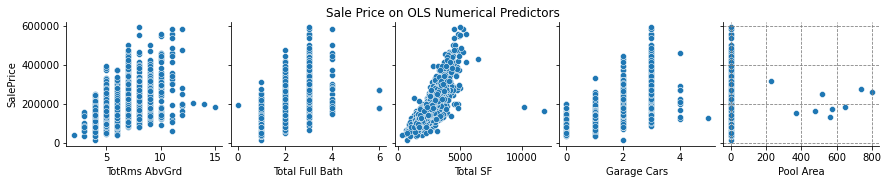

In [6]:
# Pairplot code
xcolumns1_eda = ['TotRms AbvGrd', 'Total Full Bath','Total SF','Garage Cars','Pool Area']
plt.figure(figsize=(30,15))
sns.pairplot(train_06_09, x_vars=xcolumns1_eda,y_vars='SalePrice');
plt.subplots_adjust(top=0.9)
plt.grid(b=True,color='gray',which='both',axis='both',ls='--');
plt.suptitle(t='Sale Price on OLS Numerical Predictors',
         fontdict={'fontsize':36});

In [7]:
# Coefficients of predictor variables
lr_var_coef = pd.DataFrame(list(zip(xcolumns3,lr_06_09.coef_)),columns=['var','coef'])
lr_var_coef.sort_values('coef',ascending=False)

,var,coef
14,Neighborhood_GrnHill,146607.598287
39,Overall Cond_9,84005.121045
29,Neighborhood_StoneBr,83606.558893
23,Neighborhood_NridgHt,76713.614539
38,Overall Cond_8,64567.309247
22,Neighborhood_NoRidge,61071.310036
37,Overall Cond_7,59865.164643
36,Overall Cond_6,48834.178286
35,Overall Cond_5,45437.460181
31,Neighborhood_Veenker,35474.937842


In [8]:
# OLS valuation metrics
OLScrossval = cross_val_score(lr_06_09, X_train, y_train, cv=5).mean()
OLSr2train = lr_06_09.score(X_train, y_train)
OLSr2test = lr_06_09.score(X_test, y_test)

print(f'Cross Val Score: {OLScrossval}')
print(f'Train Score: {OLSr2train}')
print(f'Test Score: {OLSr2test}')

# RMSE on train_06_09 train/test
OLSRMSEtrain = metrics.mean_squared_error(y_train, lr_06_09.predict(X_train), squared=False)
OLSRMSEtest = metrics.mean_squared_error(y_test, lr_06_09.predict(X_test), squared=False)

print(f'RMSE training: {OLSRMSEtrain}')
print(f'RMSE test: {OLSRMSEtest}')

# RMSE on train_10, using linear regression fitted on train_06_09
X_10 = train_10[xcolumns3]
OLSRMSE2010 = metrics.mean_squared_error(train_10['SalePrice'], lr_06_09.predict(X_10), squared=False)

print(f'RMSE 2010: {OLSRMSE2010}')

# Creating Linear Regression Predictions and Residuals columns
train_06_09['Linear Regression Predictions'] = lr_06_09.predict(X)
train_06_09['Linear Regression Residuals'] = train_06_09['SalePrice'] - train_06_09['Linear Regression Predictions']

train_10['Linear Regression Predictions'] = lr_06_09.predict(X_10)
train_10['Linear Regression Residuals'] = train_10['SalePrice'] - train_10['Linear Regression Predictions']

# Linear Regression Residuals
train0609OLSresids = train_06_09['Linear Regression Residuals'].mean()
train01OLSresids = train_10['Linear Regression Residuals'].mean()

print(f'Residuals 2006-2009: {train0609OLSresids}')
print(f'Residuals 2010: {train01OLSresids}')

Cross Val Score: 0.7649559906098984
Train Score: 0.8019561431965334
Test Score: 0.8002662775010404
RMSE training: 35699.63485167365
RMSE test: 34504.326581207904
RMSE 2010: 34311.4708456178
Residuals 2006-2009: -378.0382100279628
Residuals 2010: -1366.8618351577722


## Summary of OLS Regression
---
|Metric|Linear Regression|
|---|---|
|Cross Val Score|0.7649|
|$R^2_{train}$|0.8019|
|$R^2_{test}$|0.8002|
|RMSE$_{2010}$|34,311.47|
|Residuals$_{2006-2009}$|-378.04|
|Residuals$_{2010}$|-1366.86|

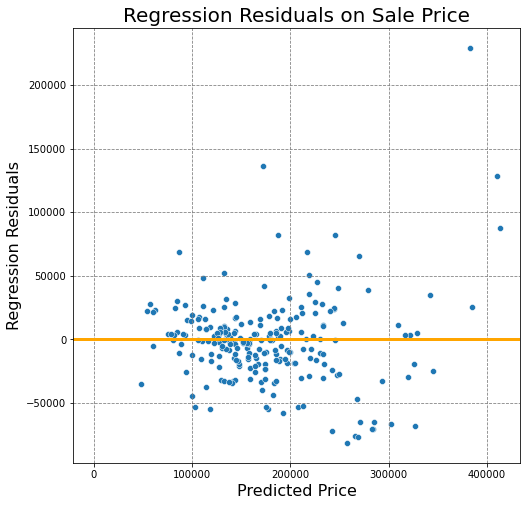

In [9]:
# Sale Price on Residuals
plt.figure(figsize=(8,8))
sns.scatterplot(y=train_10['Linear Regression Residuals'],x=train_10['Linear Regression Predictions'])
plt.grid(b=True,color='gray',which='both',axis='both',ls='--');
plt.title(label='Regression Residuals on Sale Price',fontdict={'fontsize':20});
plt.xlabel(xlabel='Predicted Price',size=16);
plt.ylabel(ylabel='Regression Residuals',size=16);
plt.axline((0,0),(1,0),color='orange',linewidth=3);

For reference, the OLS regression utilized the following features:

|Feature|Datatype|Description|
|---|---|---|
|**TotRms AbvGrd**|*integer*|Total rooms above ground, not including bathrooms|
|**Total Full Bath**|*integer*|Total full baths above ground plus basement, if applicable|
|**Total SF**|*integer*|Total square footage above ground plus basement square footage|
|**Garage Cars**|*integer*|Car capacity of the garage
|**Pool Area**|*integer*|Pool area in square feet
|**Neighborhood**|*object*|Neighborhood in which home is located. Dummified feature, with Bloomington as reference|
|**Overall Cond**|*object*|Overall condition of the house, ranging from 1-10.|

OLS Regression notes:
- Top 14 strongest coefficients are for dummy variables
- Top coefficient for numerical predictors is for garage car capacity
    - For every additional car a garage can hold, the home price increases by $18,241.66
- `'Total SF'` was suspiciously low, but this may be acceptible considering it also accounts for basement square footage
- '`Pool'` coefficient is negative, counterintuitive



## Data Cleaning for New Model
---
The goal is to construct a secondary regression model that has a higher $R^2$ for the same data (real estate data up to 2009) and achieve a lower Root Mean Squared Error for real estate data of 2010.

As such, my intent is to add non-multicollinear features that preserves as the bias-variance balance as much as possible.  

Considering these variables used in the OLS model capture most physical aspects of a home, I will be inspecting higher level aspects, to include:

`'MS SubClass','Lot Config','Bldg Type','Lot Area','Yr Sold','Mo Sold'`

In [10]:
# Inspecting columns listed above
train_06_09.sort_values('Lot Area',ascending = False)['Lot Area'].mean()
train_06_09[['Lot Config','Bldg Type','Lot Area','Yr Sold','Mo Sold']].dtypes
train_06_09[['Lot Config','Bldg Type','Lot Area','Yr Sold','Mo Sold']].isnull().sum()

Lot Config    0
Bldg Type     0
Lot Area      0
Yr Sold       0
Mo Sold       0
dtype: int64

No nulls found in the aforementioned columns and data types are correct. `'MS SubClass'` previously dummified in the consolidated data cleaning code block. `'Lot Area'` seem to have outliers, but decision to drop will be made after viewing the pairplot. `'Yr Sold'` and `'Mo Sold'` included to construct time series of mean `'SalePrice'`.

## Exploratory Data Analysis and Visualization

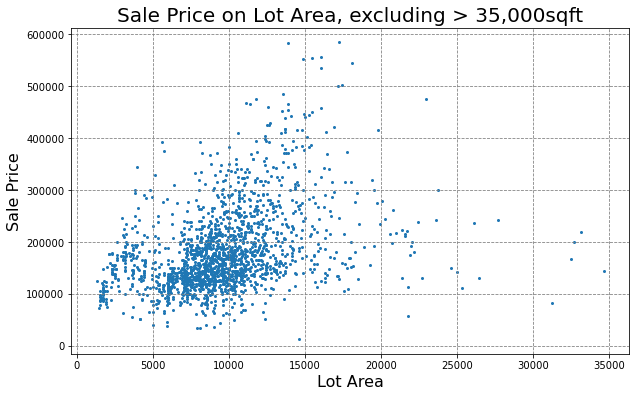

In [11]:
# Sale Price on Lot Area
train_06_09_eda_lotarea = train_06_09_eda[train_06_09_eda['Lot Area']<35000]
plt.figure(figsize=(10,6))
plt.scatter(x=train_06_09_eda_lotarea['Lot Area'],y=train_06_09_eda_lotarea['SalePrice'],s=4);
plt.title(label='Sale Price on Lot Area, excluding > 35,000sqft',fontdict={'fontsize':20});
plt.xlabel(xlabel='Lot Area',size=16);
plt.ylabel(ylabel='Sale Price',size=16);
plt.grid(b=True,color='gray',which='both',axis='both',ls='--');

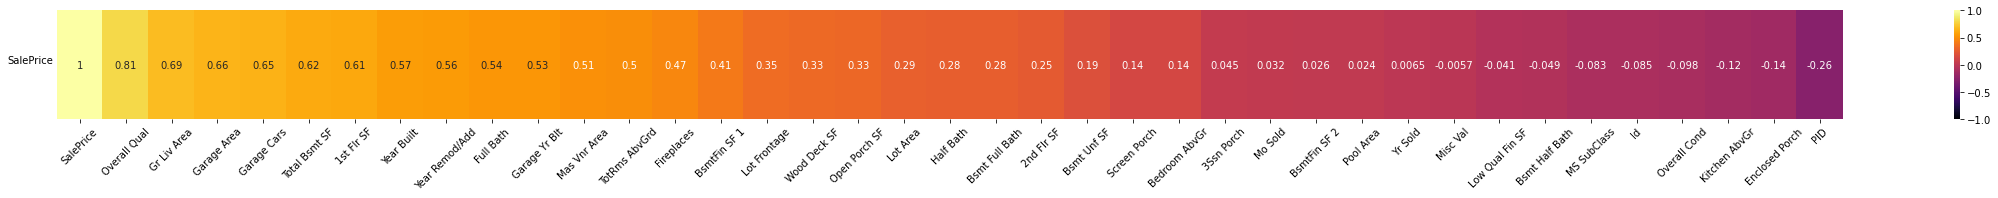

In [12]:
# Heatmap code
plt.figure(figsize=(40,2))
corr = train_06_09_eda.corr().sort_values('SalePrice',ascending=False)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr[['SalePrice']].T,cmap='inferno', annot=True,
           yticklabels=False,vmin=-1,vmax=1).invert_yaxis();
plt.xticks(rotation=45);
plt.ylabel(ylabel='SalePrice',rotation=0, horizontalalignment='right');

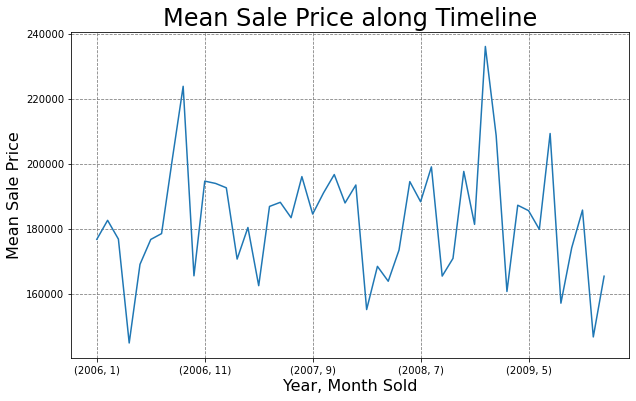

In [13]:
# Mean Sale Price as a function of time
plt.figure(figsize=(10,6))
train_06_09_eda.groupby(['Yr Sold','Mo Sold'])['SalePrice'].mean().plot();
plt.title(label='Mean Sale Price along Timeline',fontdict={'fontsize':24});
plt.ylabel(ylabel='Mean Sale Price',size=16)
plt.xlabel(xlabel='Year, Month Sold',size=16)
plt.grid(b=True,color='gray',which='both',axis='both',ls='--')

After examining visualizing some data, I decided I would neither include `'Lot Area'` not pursue constructing a feature for time using `'Yr Sold'` and `'Mo Sold'`. The time series does illuminate the downward trend of the peaks of the price.

I would, however, like to include `'MS Subclass'` and an interaction term of `'Overall Qual' * 'Overall Cond'` to take advantage of the high correlation `'Overall Qual'` and `'SalePrice'`.

## Feature Engineering
---
Feature engineering code incorporated into data cleaning code blocks to avoid errors due to recall of dropped columns for dummification. Interaction term `'Overall QualCond'` created and dummified, along with `'MS SubClass'` for the new regression models

## New Models
---
In the next few code cells, I instantiate, fit, and predict the target variable using Ridge and LASSO regression. For fair comparison, the models were run with the same predictor variables used in the OLS model. The code cells below have the models predicting on additional predictor variables (`'Overall Qualcond'` and `'MS SubClass'`).

## Ridge Regression

In [14]:
# Defining predictors, target variable; instantiating, standardizing, fitting model
xcolumns1 = ['TotRms AbvGrd', 'Total Full Bath', 'Total SF','Garage Cars', 'Pool Area']
xcolumns2 = [i for i in train_06_09.columns if 'Neighborhood' in i or 'Overall QualCond' in i or 'MS SubClass' in i]
xcolumns3 = xcolumns1 + xcolumns2

X = train_06_09[xcolumns3]
y = train_06_09['SalePrice']

poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_overfit = poly.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_overfit,y,random_state=42)
sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

r_alphas = np.logspace(0,5,100)
ridge_cv = RidgeCV(alphas=r_alphas, scoring='r2', cv=5)
ridge_cv.fit(Z_train, y_train)
opt_alpha = ridge_cv.alpha_

print(f'Optimal Alpha: {opt_alpha}')

Optimal Alpha: 954.5484566618337


## Ridge Regression Evaluation

In [15]:
# RidgeCV Valuation Metrics

# LassoCV Cross Val Score
print('Cross Val Score:',cross_val_score(ridge_cv,Z_train,y_train,cv=3).mean())

# RidgeCV R2 scores
print('Train Score:',ridge_cv.score(Z_train, y_train))
print('Test Score:',ridge_cv.score(Z_test, y_test))

# RidgeCV RMSE on train_06_09 train/test
ridgetrainRMSE = metrics.mean_squared_error(y_train, ridge_cv.predict(Z_train), squared=False)
ridgetestRMSE =  metrics.mean_squared_error(y_test, ridge_cv.predict(Z_test), squared=False)

print(f'RMSE training: {ridgetrainRMSE}')
print(f'RMSE test: {ridgetestRMSE}')

# RidgeCV RMSE on train_10, fitted on train_06_09
X_10 = train_10[xcolumns3]
X_10_overfit = poly.fit_transform(X_10)
Z_10 = sc.fit_transform(X_10_overfit)

ridgeRMSE2010 = metrics.mean_squared_error(train_10['SalePrice'], ridge_cv.predict(Z_10), squared=False)

print(f'RMSE 2010: {ridgeRMSE2010}')

# Running polynomial features and standardizing
X_06_09 = train_06_09[xcolumns3]
X_06_09_overfit = poly.fit_transform(X_06_09)
Z_06_09 = sc.fit_transform(X_06_09_overfit)

X_10 = train_10[xcolumns3]
X_10_overfit = poly.fit_transform(X_10)
Z_10 = sc.fit_transform(X_10_overfit)

# Creating RidgeCV Regression Predictions and Residuals columns
train_06_09['RidgeCV Regression Predictions'] = ridge_cv.predict(Z_06_09)
train_06_09['RidgeCV Regression Residuals'] = train_06_09['SalePrice'] - train_06_09['RidgeCV Regression Predictions']

train_10['RidgeCV Regression Predictions'] = ridge_cv.predict(Z_10)
train_10['RidgeCV Regression Residuals'] = train_10['SalePrice'] - train_10['RidgeCV Regression Predictions']

# RidgeCV Regression Residuals
train0609ridgeresids = train_06_09['RidgeCV Regression Residuals'].mean()
train10ridgeresids =train_10['RidgeCV Regression Residuals'].mean()

print(f'Residuals 2006-2009: {train0609ridgeresids}')
print(f'Residuals 2010: {train10ridgeresids}')

Cross Val Score: 0.789745876001846
Train Score: 0.9260667949201908
Test Score: 0.8795083108429984
RMSE training: 21812.36986053336
RMSE test: 26799.48226328819
RMSE 2010: 27708.27685736112
Residuals 2006-2009: -305.21984159155056
Residuals 2010: -8551.629141528396


## LASSO Regression

In [16]:
# Defining predictors, target variable; instantiating, standardizing, fitting model
xcolumns1 = ['TotRms AbvGrd', 'Total Full Bath', 'Total SF','Garage Cars', 'Pool Area']
xcolumns2 = [i for i in train_06_09.columns if 'Neighborhood' in i or 'Overall QualCond' in i or 'MS SubClass' in i]
xcolumns3 = xcolumns1 + xcolumns2

X = train_06_09[xcolumns3]
y = train_06_09['SalePrice']

poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_overfit = poly.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_overfit,y,random_state=42)
sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

l_alphas = np.logspace(2,5,100)
lasso_cv = LassoCV(alphas = l_alphas, cv=5, max_iter = 50000)
lasso_cv.fit(Z_train, y_train)
opt_alpha = lasso_cv.alpha_

print(f'Optimal Alpha: {opt_alpha}')

Optimal Alpha: 811.1308307896873


## LASSO Regression Evaluation

In [17]:
# LassoCV Valuation Metrics

# LassoCV Cross Val Score
print('Cross Val Score:',cross_val_score(lasso_cv,Z_train,y_train,cv=3).mean())

# LassoCV R2 scores
print('Train Score:',lasso_cv.score(Z_train, y_train))
print('Test Score:',lasso_cv.score(Z_test, y_test))

# LassoCV RMSE on train_06_09 train/test
lassotrainRMSE = metrics.mean_squared_error(y_train, lasso_cv.predict(Z_train), squared=False)
lassotestRMSE =  metrics.mean_squared_error(y_test, lasso_cv.predict(Z_test), squared=False)

print(f'RMSE training: {lassotrainRMSE}')
print(f'RMSE test: {lassotestRMSE}')

# LassoCV RMSE on train_10, fitted on train_06_09
X_10 = train_10[xcolumns3]
X_10_overfit = poly.fit_transform(X_10)
Z_10 = sc.fit_transform(X_10_overfit)

lassoRMSE2010 = metrics.mean_squared_error(train_10['SalePrice'], lasso_cv.predict(Z_10), squared=False)

print(f'RMSE 2010: {lassoRMSE2010}')

# Running polynomial features and standardizing
X_06_09 = train_06_09[xcolumns3]
X_06_09_overfit = poly.fit_transform(X_06_09)
Z_06_09 = sc.fit_transform(X_06_09_overfit)

X_10 = train_10[xcolumns3]
X_10_overfit = poly.fit_transform(X_10)
Z_10 = sc.fit_transform(X_10_overfit)

# Creating LassoCV Regression Predictions and Residuals columns
train_06_09['LassoCV Regression Predictions'] = lasso_cv.predict(Z_06_09)
train_06_09['LassoCV Regression Residuals'] = train_06_09['SalePrice'] - train_06_09['LassoCV Regression Predictions']

train_10['LassoCV Regression Predictions'] = lasso_cv.predict(Z_10)
train_10['LassoCV Regression Residuals'] = train_10['SalePrice'] - train_10['LassoCV Regression Predictions']

# LassoCV Regression Residuals
train0609lassoresids = train_06_09['LassoCV Regression Residuals'].mean()
train10lassoresids = train_10['LassoCV Regression Residuals'].mean()

print(f'Residuals 2006-2009: {train0609lassoresids}')
print(f'Residuals 2010: {train10lassoresids}')

Cross Val Score: 0.7939667402015305
Train Score: 0.9334262984926059
Test Score: 0.8892271897837933
RMSE training: 20698.288621273296
RMSE test: 25695.93614810414
RMSE 2010: 27329.004153319547
Residuals 2006-2009: -305.2198415915424
Residuals 2010: -8551.629141528409


## Summary of Regression Metrics
---
|Metric|Linear|Ridge|Ridge (New Predictors)|LASSO|LASSO (New Predictors)|
|---|---|---|---|---|---|
|Cross Val Score|0.7649|0.7623|0.7897|0.8034|0.8021|
|$R^2_{train}$|0.8019|0.9103|0.9261|0.9095|0.9334|
|$R^2_{test}$|0.8002|0.8313|0.8795|0.8319|0.8938|
|RMSE$_{2010}$|34,311.47|28,506.35|27,708.28|28,511.96|27,479.60|
|Residuals$_{2006-2009}$|-378.04|-305.22|-305.22|-305.22|-305.22|
|Residuals$_{2010}$|-1,366.86|-8,551.63|-8,551.63|-8,551.63|-8,511.63|
|optimal $\alpha$|---|1.5922|954.5484|30.7029|811.1308

Hyper parameters Lasso with old predictors: `l_alphas=np.logspace(0,3,100)`

Hyper parameters Lasso with new predictors: `l_alphas=np.logspace(2,5,100)`

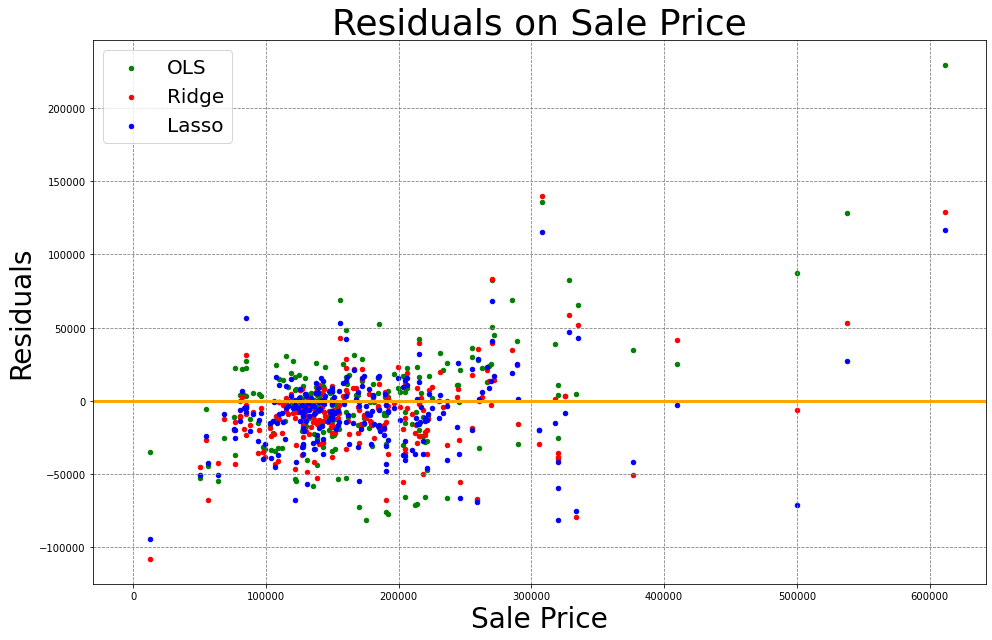

In [18]:
# Comparing residuals
fig ,ax = plt.subplots(figsize=(16,10));
train_10.plot(kind='scatter',x="SalePrice",y="Linear Regression Residuals", color="g",
                label="OLS", ax=ax);
train_10.plot(kind='scatter',x="SalePrice",y="RidgeCV Regression Residuals", color="r",
                label="Ridge", ax=ax);
train_10.plot(kind="scatter", x="SalePrice",y="LassoCV Regression Residuals", color="b",
                label="Lasso",ax=ax);

ax.set_title(label='Residuals on Sale Price',fontdict={'size':36})
ax.set_xlabel(xlabel='Sale Price',fontdict={'size':28})
ax.set_ylabel('Residuals',fontdict={'size':28})
plt.grid(b=True,color='gray',which='both',axis='both',ls='--')
plt.axline((0,0),(1,0),color='orange',linewidth=3)
plt.legend(prop={'size':20})
plt.show()

## Conclusions
---
Both Ridge and LASSO regressions scored higher than the OLS model for both train and the test subsets. When additional predictors were introduced to the new models, they scored even higher.

Both models did turn out overfit, with LASSO (with new predictors) as the least overfit.

Of all four, LASSO (with new predictors) had the biggest reduction in RMSE$_{2010}$.

One short-coming of the model is that, after having fit and transformed with polynomial features, the model features exploded to over 3,000, diminishing its interpretability.

## Recommendations
---
I recommend that management adopt LASSO (with new predictors) to capitalize on the biggest decrease in RMSE.

Considering the company's business model is to buy homes, repair them, and re-list the homes. I would advise that the company offer lower than the asking price for homes and use the repairs required as justification.

Last note:

Recalling this graph below, it is important to note that the model has a negative mean of residuals. This means that the model is overestimating prices. The model is trained on two years of data prior to the financial crisis. The significantly lower residuals for 2010 indicates that the latent effect of the crisis is taking its toll on the Ames housing market. I recommend re-examining the model more frequently.

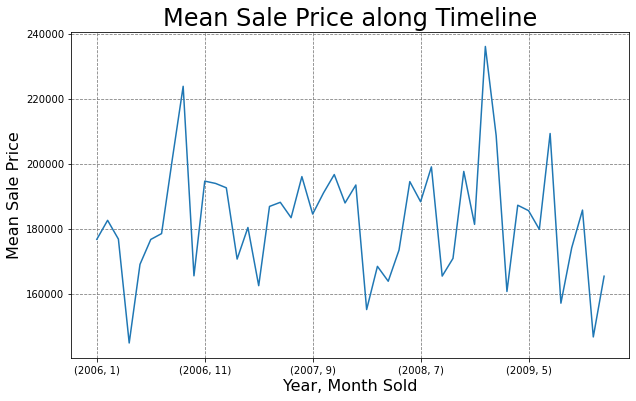

In [19]:
# Mean Sale Price as a function of time
plt.figure(figsize=(10,6))
train_06_09_eda.groupby(['Yr Sold','Mo Sold'])['SalePrice'].mean().plot();
plt.title(label='Mean Sale Price along Timeline',fontdict={'fontsize':24});
plt.ylabel(ylabel='Mean Sale Price',size=16)
plt.xlabel(xlabel='Year, Month Sold',size=16)
plt.grid(b=True,color='gray',which='both',axis='both',ls='--')

## References
---
- ([Ames Housing Data Dictionary](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt))
- ([VentureBeat](https://venturebeat.com/2021/08/04/opendoor-on-using-data-science-to-close-real-estate-deals/)) article that was inspiration for hypothetical company
- Residuals plot inspired by user ([ImportanceOfBeingErnes](https://stackoverflow.com/questions/43061768/plotting-multiple-scatter-plots-pandas)) from Stackoverflow